## **Model Compression (Quantization and Pruning)** ##

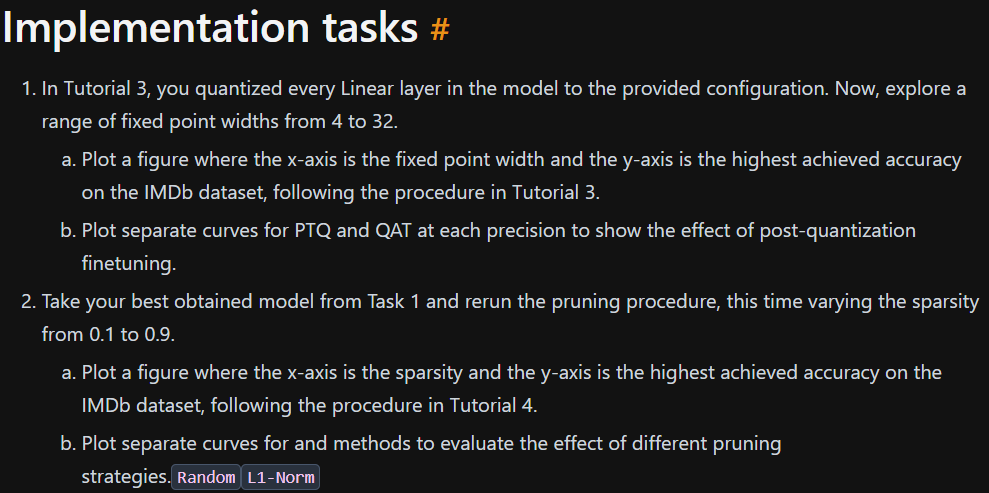

In [6]:
""" load model """

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")


/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch

tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-0.1709,  0.5230, -0.8713,  ..., -1.3382,  0.5892,  0.4026],
         [-0.5842,  0.9588,  1.5642,  ..., -1.0731, -0.7330,  0.3132],
         [-0.8601, -1.3756,  0.5042,  ..., -0.0476,  0.2650,  1.2150],
         ...,
         [ 0.0520,  1.1719, -1.5471,  ..., -0.7894,  0.1419,  1.6964],
         [ 0.7654, -1.5053, -0.4142,  ..., -1

In [7]:
""" original accuracy """
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Evaluation accuracy: 0.8352


In [8]:
""" hyper_prams for lab3 """
hyper_prams=[i for i in range(4,33)]
accuracies=[]
precision_PTQ=[]
precision_QAT=[]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score

def compute_metrics(pred):
    # 获取预测值和真实标签
    predictions, labels = pred
    predictions = predictions.argmax(axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
    }


In [ ]:
from pathlib import Path
for i, hyper_pram in enumerate(hyper_prams):
    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": hyper_pram,
                "data_in_frac_width": 4,
                # weight
                "weight_width": hyper_pram,
                "weight_frac_width": 4,
                # bias
                "bias_width": hyper_pram,
                "bias_frac_width": 4,
            }
        },
    }

    mg_, _ = passes.quantize_transform_pass(
        mg,
        pass_args=quantization_config,
    )

    trainer = get_trainer(
        model=mg_.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )
    eval_results = trainer.evaluate()
    accuracies.append(eval_results['eval_accuracy'])
    # precision_PTQ.append(eval_results['eval_precision'])
    print(f"Evaluation PTQ accuracy: {eval_results['eval_accuracy']}")
    # print(f"Evaluation PTQ precision: {eval_results['eval_precision']}")


    trainer.train()
    eval_results = trainer.evaluate()
    precision_QAT.append(eval_results['eval_accuracy'])
    print(f"Evaluation QAT accuracy: {eval_results['eval_accuracy']}")
    mg_.export(f"{Path.home()}/lab_{i}_best_qat")


Evaluation PTQ accuracy: 0.62524


Step,Training Loss
500,0.617800
1000,0.535300
1500,0.507500
2000,0.501100
2500,0.473800
3000,0.485900


Evaluation QAT accuracy: 0.78916


Evaluation PTQ accuracy: 0.73804


Step,Training Loss
500,0.496600
1000,0.448800
1500,0.447900
2000,0.457000
2500,0.435500
3000,0.432500


Evaluation QAT accuracy: 0.81584


Evaluation PTQ accuracy: 0.80392


Step,Training Loss
500,0.433500
1000,0.405800
1500,0.410700
2000,0.419200
2500,0.403700
3000,0.393400


Evaluation QAT accuracy: 0.83732


Evaluation PTQ accuracy: 0.82636


Step,Training Loss
500,0.421400
1000,0.393200
1500,0.403500
2000,0.407100
2500,0.391000
3000,0.388800


Evaluation QAT accuracy: 0.84084


Evaluation PTQ accuracy: 0.8284


Step,Training Loss
500,0.422100
1000,0.399500
1500,0.401800
2000,0.408700
2500,0.391500
3000,0.390600


Evaluation QAT accuracy: 0.84012


Evaluation PTQ accuracy: 0.8268


Step,Training Loss
500,0.422600
1000,0.398200
1500,0.403000
2000,0.408700
2500,0.390800
3000,0.390400


Evaluation QAT accuracy: 0.83948


Evaluation PTQ accuracy: 0.8274


Step,Training Loss
500,0.423300
1000,0.397700
1500,0.402800
2000,0.407900
2500,0.391500
3000,0.391400


Evaluation QAT accuracy: 0.83928


Evaluation PTQ accuracy: 0.828


Step,Training Loss
500,0.422700
1000,0.398600
1500,0.402500
2000,0.408200
2500,0.391900
3000,0.392100


Evaluation QAT accuracy: 0.84028


Evaluation PTQ accuracy: 0.82792


Step,Training Loss
500,0.423900
1000,0.399500
1500,0.402000
2000,0.409800
2500,0.391200
3000,0.394300


Evaluation QAT accuracy: 0.84016


Evaluation PTQ accuracy: 0.8278


Step,Training Loss
500,0.421900
1000,0.399200
1500,0.402100
2000,0.408100
2500,0.391100
3000,0.391800


Evaluation QAT accuracy: 0.83976


Evaluation PTQ accuracy: 0.82816


Step,Training Loss
500,0.423100
1000,0.398800
1500,0.403600
2000,0.409400
2500,0.392100
3000,0.393000


Evaluation QAT accuracy: 0.84


Evaluation PTQ accuracy: 0.82832


Step,Training Loss
500,0.422300
1000,0.397400
1500,0.404100
2000,0.409800
2500,0.394400
3000,0.393200


Evaluation QAT accuracy: 0.83952


Evaluation PTQ accuracy: 0.82864


Step,Training Loss
500,0.422700
1000,0.398800
1500,0.401600
2000,0.408900
2500,0.391900
3000,0.391900


Evaluation QAT accuracy: 0.83964


Evaluation PTQ accuracy: 0.82816


Step,Training Loss
500,0.422800
1000,0.397200
1500,0.402400
2000,0.408100
2500,0.391700
3000,0.392300


Evaluation QAT accuracy: 0.839


Evaluation PTQ accuracy: 0.82844


Step,Training Loss
500,0.421400
1000,0.397600
1500,0.404200
2000,0.407800
2500,0.392100
3000,0.392900


Evaluation QAT accuracy: 0.83992


Evaluation PTQ accuracy: 0.82944


Step,Training Loss
500,0.421500
1000,0.396400
1500,0.400000
2000,0.407000
2500,0.391000
3000,0.392400


Evaluation QAT accuracy: 0.84088


Evaluation PTQ accuracy: 0.829


Step,Training Loss
500,0.421600
1000,0.398400
1500,0.401500
2000,0.407100
2500,0.391600
3000,0.393200


Evaluation QAT accuracy: 0.84084


Evaluation PTQ accuracy: 0.82844


Step,Training Loss
500,0.420800
1000,0.397100
1500,0.401100
2000,0.406200
2500,0.389900
3000,0.393100


Evaluation QAT accuracy: 0.84064


Evaluation PTQ accuracy: 0.8292


Step,Training Loss
500,0.421000
1000,0.397900
1500,0.401700
2000,0.407500
2500,0.391100
3000,0.393000


Evaluation QAT accuracy: 0.84012


Evaluation PTQ accuracy: 0.82932


Step,Training Loss
500,0.421300
1000,0.397800
1500,0.400800
2000,0.407400
2500,0.392400
3000,0.391800


Evaluation QAT accuracy: 0.83992


Evaluation PTQ accuracy: 0.82912


Step,Training Loss
500,0.421300
1000,0.398600
1500,0.401900
2000,0.405600
2500,0.392000
3000,0.391500


Evaluation QAT accuracy: 0.84096


Evaluation PTQ accuracy: 0.82904


Step,Training Loss
500,0.421100
1000,0.398200
1500,0.401300
2000,0.408200
2500,0.393200
3000,0.393100


Evaluation QAT accuracy: 0.84024


Evaluation PTQ accuracy: 0.82864


Step,Training Loss
500,0.420400
1000,0.398500
1500,0.401300
2000,0.408200
2500,0.390700
3000,0.393900


Evaluation QAT accuracy: 0.84044


Evaluation PTQ accuracy: 0.82868


Step,Training Loss
500,0.419400
1000,0.396500
1500,0.401600
2000,0.405700
2500,0.392100
3000,0.394400


Evaluation QAT accuracy: 0.84044


Evaluation PTQ accuracy: 0.82884


Step,Training Loss
500,0.420700
1000,0.397100
1500,0.400600
2000,0.407000
2500,0.392200
3000,0.391400


Evaluation QAT accuracy: 0.84016


Evaluation PTQ accuracy: 0.82832


Step,Training Loss
500,0.421000
1000,0.396200
1500,0.401100
2000,0.407600
2500,0.391000
3000,0.394400


Evaluation QAT accuracy: 0.84012


Evaluation PTQ accuracy: 0.8282


Step,Training Loss
500,0.419400
1000,0.396500
1500,0.401700
2000,0.408000
2500,0.391200
3000,0.393100


Evaluation QAT accuracy: 0.8402


Evaluation PTQ accuracy: 0.82868


Step,Training Loss
500,0.419800
1000,0.394600
1500,0.401700
2000,0.407400
2500,0.390900
3000,0.392300


Evaluation QAT accuracy: 0.8396


Evaluation PTQ accuracy: 0.829


Step,Training Loss
500,0.420100
1000,0.398900
1500,0.400300
2000,0.406900
2500,0.391900
3000,0.391600


Evaluation QAT accuracy: 0.84064


In [22]:
len(hyper_prams)
len(precision_QAT)
len(accuracies)


29

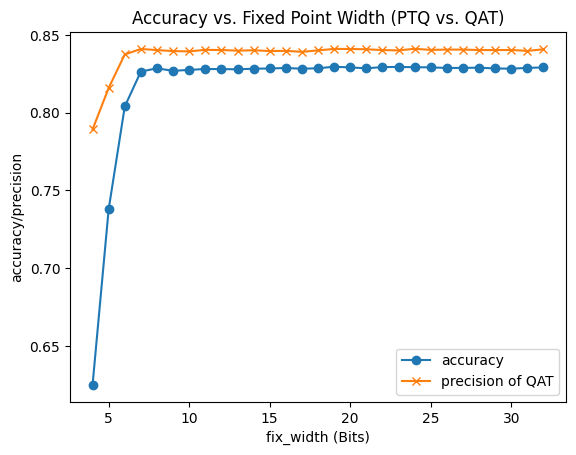

In [26]:
""" plot """
from  matplotlib import pyplot as plt
plt.figure()
plt.plot(hyper_prams, accuracies, '-o', label='accuracy')
# plt.plot(hyper_prams, precision_PTQ, 'x', label='precision of PTQ')
plt.plot(hyper_prams, precision_QAT, '-x', label='precision of QAT')
plt.xlabel('fix_width (Bits)')
plt.ylabel('accuracy/precision')
plt.legend()
plt.title('Accuracy vs. Fixed Point Width (PTQ vs. QAT)')
plt.show()



In [31]:
m=max(precision_QAT)
print(precision_QAT.index(m))
print(precision_QAT[precision_QAT.index(m)],m)
print(hyper_prams[precision_QAT.index(m)])

20
0.84096 0.84096
24


In [33]:
precision_QAT

[0.78916,
 0.81584,
 0.83732,
 0.84084,
 0.84012,
 0.83948,
 0.83928,
 0.84028,
 0.84016,
 0.83976,
 0.84,
 0.83952,
 0.83964,
 0.839,
 0.83992,
 0.84088,
 0.84084,
 0.84064,
 0.84012,
 0.83992,
 0.84096,
 0.84024,
 0.84044,
 0.84044,
 0.84016,
 0.84012,
 0.8402,
 0.8396,
 0.84064,
 0.83952]

In [1]:
""" get the best model (I didn't save wight damn I have to train again)  """
hyper_pram=24
quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": hyper_pram,
            "data_in_frac_width": 4,
            # weight
            "weight_width": hyper_pram,
            "weight_frac_width": 4,
            # bias
            "bias_width": hyper_pram,
            "bias_frac_width": 4,
        }
    },
}

mg_, _ = passes.quantize_transform_pass(
    mg,
    pass_args=quantization_config,
)

trainer = get_trainer(
    model=mg_.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)
eval_results = trainer.evaluate()
accuracies.append(eval_results['eval_accuracy'])
# precision_PTQ.append(eval_results['eval_precision'])
print(f"Evaluation PTQ accuracy: {eval_results['eval_accuracy']}")
# print(f"Evaluation PTQ precision: {eval_results['eval_precision']}")


trainer.train()
eval_results = trainer.evaluate()
precision_QAT.append(eval_results['eval_accuracy'])
print(f"Evaluation QAT accuracy: {eval_results['eval_accuracy']}")

from pathlib import Path

mg_.export(f"{Path.home()}/lab_1_best_qat")

NameError: name 'passes' is not defined

In [1]:
import chop.passes as passes

hyper_prams_2=[i/10 for i in range(1,10)]
accuracies_random=[]
accuracies_l1_norm=[]
accuracies_random_pre=[]
accuracies_l1_norm_pre=[]
print(hyper_prams_2)

/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [7]:
from chop.tools import get_tokenized_dataset, get_trainer
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

from pathlib import Path
from chop import MaseGraph

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)
mg = MaseGraph.from_checkpoint(f"{Path.home()}/lab_1_best_qat")
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)
eval_results = trainer.evaluate()
print(f"Evaluation best accuracy: {eval_results['eval_accuracy']}")

/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[[-0.1709,  0.5230, -0.8713,  ..., -1.3382,  0.5892,  0.4026],
         [-0.5842,  0.9588,  1.5642,  ..., -1.0731, -0.7330,  0.3132],
         [-0.8601, -1.3756,  0.5042,  ..., -0.0476,  0.2650,  1.2150],
         ...,
         [ 0.0520,  1.1719, -1.5471,  ..., -0.7894,  0.1419,  1.6964],
         [ 0.7654, -1.5053, -0.4142,  ..., -1

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Evaluation best accuracy: 0.841


In [3]:
import torch
from pathlib import Path

def export_model_state(model, fname):
    """
    保存模型的状态字典
    Args:
        model: PyTorch 模型
        fname: 保存文件的路径（不含扩展名）
    """
    # 保存状态字典
    state_dict_path = f"{fname}.pt"
    torch.save(model.state_dict(), state_dict_path)
    print(f"Model state_dict saved to {state_dict_path}")

    # 如果需要保存元数据或额外信息，可以单独保存
    metadata_path = f"{fname}_metadata.json"
    metadata = {"description": "Exported model state dict", "version": 1.0}
    with open(metadata_path, "w") as meta_file:
        import json
        json.dump(metadata, meta_file)
    print(f"Metadata saved to {metadata_path}")


In [8]:
accuracies_random_pre=[]
for i,hyper_prams in enumerate(hyper_prams_2):
    pruning_config_1 = {
        "weight": {
            "sparsity": hyper_prams,
            "method": "random",
            "scope": "local",
        },
        "activation": {
            "sparsity": hyper_prams,
            "method": "random",
            "scope": "local",
        },
    }
    mg_1, _ = passes.prune_transform_pass(mg, pass_args=pruning_config_1)

    trainer_1 = get_trainer(
        model=mg_1.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=5,
    )

    # Evaluate accuracy
    eval_results_1 = trainer_1.evaluate()
    print(f"Evaluation Random for {hyper_prams} accuracy: {eval_results_1['eval_accuracy']}")
    accuracies_random_pre.append(eval_results_1['eval_accuracy'])



INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense


INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation Random for 0.1 accuracy: 0.69092


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation Random for 0.2 accuracy: 0.54328


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation Random for 0.3 accuracy: 0.50532


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation Random for 0.4 accuracy: 0.4972


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation Random for 0.5 accuracy: 0.5016


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation Random for 0.6 accuracy: 0.50052


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation Random for 0.7 accuracy: 0.5


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation Random for 0.8 accuracy: 0.5


Evaluation Random for 0.9 accuracy: 0.5


In [4]:
mg = MaseGraph.from_checkpoint(f"{Path.home()}/lab_1_best_qat")
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)
eval_results = trainer.evaluate()
print(f"Evaluation best accuracy: {eval_results['eval_accuracy']}")

Evaluation best accuracy: 0.841


In [5]:
for i,hyper_prams in enumerate(hyper_prams_2):
    pruning_config_2 = {
        "weight": {
            "sparsity": hyper_prams,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": hyper_prams,
            "method": "l1-norm",
            "scope": "local",
        },
    }
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/lab_1_best_qat")
    mg_2, _ = passes.prune_transform_pass(mg, pass_args=pruning_config_2)

    trainer_2 = get_trainer(
        model=mg_2.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=5,
    )

    # Evaluate accuracy
    eval_results_2 = trainer_2.evaluate()
    print(f"Evaluation l1-norm for {hyper_prams} accuracy: {eval_results_2['eval_accuracy']}")
    accuracies_l1_norm_pre.append(eval_results_2['eval_accuracy'])



INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation l1-norm for 0.1 accuracy: 0.84088


Evaluation l1-norm for 0.2 accuracy: 0.8398


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation l1-norm for 0.3 accuracy: 0.83256


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation l1-norm for 0.4 accuracy: 0.80532


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation l1-norm for 0.5 accuracy: 0.75548


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation l1-norm for 0.6 accuracy: 0.73152


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation l1-norm for 0.7 accuracy: 0.55928


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Evaluation l1-norm for 0.8 accuracy: 0.53032


Evaluation l1-norm for 0.9 accuracy: 0.50208


In [ ]:
for i,hyper_prams in enumerate(hyper_prams_2):
    pruning_config_1 = {
        "weight": {
            "sparsity": hyper_prams,
            "method": "random",
            "scope": "local",
        },
        "activation": {
            "sparsity": hyper_prams,
            "method": "random",
            "scope": "local",
        },
    }
    pruning_config_2 = {
        "weight": {
            "sparsity": hyper_prams,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": hyper_prams,
            "method": "l1-norm",
            "scope": "local",
        },
    }
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/lab_1_best_qat")
    mg_1, _ = passes.prune_transform_pass(mg, pass_args=pruning_config_1)
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/lab_1_best_qat")
    mg_2, _ = passes.prune_transform_pass(mg, pass_args=pruning_config_2)

    trainer_1 = get_trainer(
        model=mg_1.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=5,
    )

    # Evaluate accuracy
    eval_results_1 = trainer_1.evaluate()
    print(f"Evaluation Random for {hyper_prams} accuracy: {eval_results_1['eval_accuracy']}")
    accuracies_random_pre.append(eval_results_1['eval_accuracy'])

    trainer_2 = get_trainer(
        model=mg_2.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=5,
    )

    # Evaluate accuracy
    eval_results_2 = trainer_2.evaluate()
    print(f"Evaluation l1-norm for {hyper_prams} accuracy: {eval_results_2['eval_accuracy']}")
    accuracies_l1_norm_pre.append(eval_results_2['eval_accuracy'])

    # trainer_1.train()

    # eval_results_1 = trainer_1.evaluate()
    # print(f"Evaluation Random for {hyper_prams} accuracy after training: {eval_results_1['eval_accuracy']}") 
    # accuracies_random.append(eval_results_1['eval_accuracy'])
    # export_model_state(mg_1.model, f"{Path.home()}/lab_1_random_{i}_qat")

    # trainer_2.train()
    # eval_results_2 = trainer_2.evaluate()
    # print(f"Evaluation l1-norm for {hyper_prams} accuracy after training: {eval_results_2['eval_accuracy']}")
    # accuracies_l1_norm.append(eval_results_2['eval_accuracy'])
    # export_model_state(mg_2.model, f"{Path.home()}/lab_1_l1_norm_{i}_qat")



In [6]:
accuracies_l1_norm_pre

[0.84088,
 0.8398,
 0.83256,
 0.80532,
 0.75548,
 0.73152,
 0.55928,
 0.53032,
 0.50208]

In [9]:
accuracies_random_pre

[0.69092, 0.54328, 0.50532, 0.4972, 0.5016, 0.50052, 0.5, 0.5, 0.5]

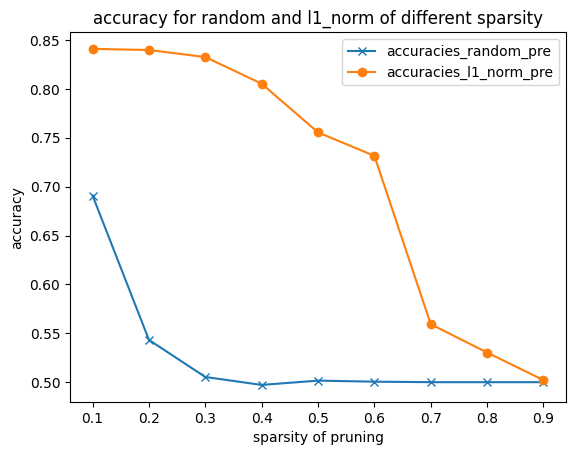

In [10]:
""" plot """
from  matplotlib import pyplot as plt
plt.figure()
plt.plot(hyper_prams_2, accuracies_random_pre, '-x', label='accuracies_random_pre')
# plt.plot(hyper_prams, precision_PTQ, 'x', label='precision of PTQ')
plt.plot(hyper_prams_2, accuracies_l1_norm_pre, '-o', label='accuracies_l1_norm_pre')
plt.xlabel('sparsity of pruning')
plt.ylabel('accuracy')
plt.legend()
plt.title('accuracy for random and l1_norm of different sparsity')
plt.show()


In [ ]:
# 加载模型
import torch

# 假设你的模型类是 MyModel
model = MyModel()  # 初始化模型
state_dict_path = f"{Path.home()}/lab_1_random_{i}_qat.pt"
model.load_state_dict(torch.load(state_dict_path))  # 加载状态字典
model.eval()  # 设置模型为推理模式


## **clear**